# Packages

In [1]:
import functions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from pandas.plotting import scatter_matrix
from scipy.stats import boxcox
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_curve, roc_auc_score
from numpy import mean, std
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
import xgboost as xgb

from sklearn.preprocessing import LabelEncoder
import time
from sklearn import metrics
from collections import Counter
from sklearn.feature_selection import mutual_info_classif,f_classif
from sklearn.feature_selection import VarianceThreshold, SelectKBest # Feature selector
from sklearn.pipeline import Pipeline # For setting up pipeline
from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler, PowerTransformer, MaxAbsScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import joblib
from matplotlib.colors import ListedColormap
from sklearn.metrics import make_scorer,matthews_corrcoef, average_precision_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier,plot_tree,export_text
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler, PowerTransformer, MaxAbsScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV # For optimization
import warnings

warnings.filterwarnings('ignore')

In [2]:
# Set the default text font size
plt.rc('font', size=12)# Set the axes title font size
plt.rc('axes', titlesize=12)# Set the axes labels font size
plt.rc('axes', labelsize=12)# Set the font size for x tick labels
plt.rc('xtick', labelsize=12)# Set the font size for y tick labels
plt.rc('ytick', labelsize=12)# Set the legend font size
plt.rc('legend', fontsize=12)# Set the font size of the figure title
plt.rc('figure', titlesize=12)

# Data

In [3]:
df_preprocessed=pd.read_csv('df_after_preprocessing.csv',index_col=0)

final_variables=['BHWinstreak', 'BHLosestreak', 'BAWinstreak', 'BALosestreak', 'cHS',
       'cHF', 'cHY', 'cHR', 'r3FTHG', 'r3HC', 'r3HY', 'r3HR', 'r4HR', 'r5HR',
       'WinsOverH', 'LossesOverH', 'WinstreakH', 'LosestreakH', 'cAF', 'cAR',
       'r3AC', 'r3AF', 'r3AY', 'r3AR', 'r4AR', 'r5FTAG', 'r5AR', 'ewm03_xGA',
       'LoserateA', 'WinsOverA', 'LossesOverA', 'WinstreakA', 'LosestreakA',
       'RestH', 'RestYesNoH', 'FormationCatH', 'FormationChangeH', 'RestA',
       'RestYesNoA', 'FormationCatA', 'FormationChangeA', 'Markov_ratingH',
       'OD_ratingH', 'OD_ratingA', 'SpreadH', 'SpreadA', 'SpreadD', 'HomeAdv',
       'HomeAdv2', 'HomeAdv3', 'HAvgAge', 'HForeigner', 'AAvgAge',
       'AForeigner']
target=['FTR']

df=df_preprocessed[final_variables+target]

X_train,X_test,y_train,y_test=functions.train_test_split(df=df,features='all',start=10,window=20,forecast=8)

y_test_adh=y_test.copy()
y_train = LabelEncoder().fit_transform(y_train.values.ravel())
y_test = LabelEncoder().fit_transform(y_test.values.ravel())
print(Counter(y_train))
print(Counter(y_test))

Counter({2: 90, 0: 65, 1: 45})
Counter({2: 37, 0: 26, 1: 17})


# Functions

In [4]:
rps_scorer= make_scorer(functions.rps, needs_proba=True,greater_is_better=False)
roc_auc_ovr_scorer = make_scorer(roc_auc_score, needs_proba=True,multi_class='ovr')
auprc= make_scorer(functions.multi_auprc, needs_proba=True, greater_is_better=True)

In [5]:
def run_classifier(clf, param_grid, title,X_train,y_train):
    # -----------------------------------------------------
    
    pipe = Pipeline([
    ('classifier', clf)
    ])

    # -----------------------------------------------
    
    scoring = {"Accuracy": 'accuracy',"Log_loss":'neg_log_loss',"Precision":make_scorer(precision_score, average = 'macro'),'Recall': make_scorer(recall_score, average = 'macro'),
               'Matthews_corrcoef': make_scorer(matthews_corrcoef),'F1_score':'f1_macro',"AUC":roc_auc_ovr_scorer, 'RPS': rps_scorer}
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
    grid = GridSearchCV(pipe, param_grid, cv=cv,scoring=scoring,refit='Accuracy',n_jobs=-1,verbose=1).fit(X_train, y_train)

    # -----------------------------------------------------
    print("The best parameters are %s" % (grid.best_params_)) 

    #y_pred = grid.best_estimator_.predict(X_test)
    #y_proba = grid.best_estimator_.predict_proba(X_test)

    # -----------------------------------------------------

    joblib.dump(grid, 'grid_'+title+'.pkl')

    #------------------------------------------------


def classifier_plots(grid):
    #-----------------------------------------------------------
    
    y_pred = grid.best_estimator_.predict(X_test)
    y_proba = grid.best_estimator_.predict_proba(X_test)

    # -----------------------------------------------------
    # CONFUSSION MATRIX
    #------------------------------------------------------

    fig, ax = plt.subplots(1, 1, figsize = (12,6))
    cm = confusion_matrix(y_test, y_pred)#, labels= target_names)
    sns.heatmap(cm, annot = True, cbar = False, fmt = "d", linewidths = .5, cmap = "Blues", ax = ax)
    #ax.set_title("Macierz błędów")
    ax.set_xlabel("Klasa predykowana")
    ax.set_ylabel("Klasa rzeczywista")
    target_names=['Gość', 'Remis', 'Gospodarz']
    ax.set_xticklabels(target_names)
    ax.set_yticklabels(target_names)
    fig.tight_layout()
    fig.savefig("xgb_conf_matrix.jpg",bbox_inches='tight')
    plt.show()  

    # -----------------------------------------------------

    print('Accuracy score: %.2f%%' %(accuracy_score(y_test, y_pred)*100))  
    print('Precision score: %.2f%%' % (precision_score(y_test, y_pred, average= 'weighted')*100))
    print('Recall score: %.2f%%' % (recall_score(y_test, y_pred, average= 'weighted')*100))
    print('---------------------------------')

    #------------------------------------------------------------
    # ROC CURVES AND HISTOGRAMS
    #-----------------------------------------------------------
    
    classes = grid.classes_
    classes_names=['Gość', 'Remis', 'Gospodarz']

    plt.figure(figsize = (16,9))
    bins = [i/20 for i in range(20)] + [1]
    roc_auc_ovr = {}

    for i in range(len(classes)):
        # Gets the class
        c = classes[i]
        cn=classes_names[i]

        # Prepares an auxiliar dataframe to help with the plots
        df_aux = X_test.copy()
        df_aux['class'] = [1 if y == c else 0 for y in y_test]
        df_aux['prob'] = y_proba[:, i]
        df_aux = df_aux.reset_index(drop = True)
        
        # Plots the probability distribution for the class and the rest
        ax = plt.subplot(2, 3, i+1)
        sns.histplot(x = "prob", data = df_aux, hue = 'class', color = 'b', ax = ax, bins = bins)
        ax.set_title(cn)
        ax.legend([f"Klasa: {cn}", "Reszta"])
        ax.set_xlabel(f"P(x = {cn})")
        
        # Calculates the ROC Coordinates and plots the ROC Curves
        ax_bottom = plt.subplot(2, 3, i+4)
        tpr, fpr = functions.get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
        functions.plot_roc_curve(tpr, fpr, scatter = False, ax = ax_bottom)
        ax_bottom.set_title("Krzywa ROC OvR")
        
        # Calculates the ROC AUC OvR
        roc_auc_ovr[c] = roc_auc_score(df_aux['class'], df_aux['prob'])
        
    plt.tight_layout()
    plt.savefig("xgb_roc_auc.jpg",bbox_inches='tight')
    plt.show()

    # Displays the ROC AUC for each class
    avg_roc_auc = 0
    i = 0
    for k in roc_auc_ovr:
        avg_roc_auc += roc_auc_ovr[k]
        i += 1
        print(f"{k} ROC AUC OvR: {roc_auc_ovr[k]:.4f}")
    print(f"average ROC AUC OvR: {avg_roc_auc/i:.4f}")
    print('---------------------------------')


# XGBoost

### Basic model

In [6]:
pipe = Pipeline([
('classifier', xgb.XGBClassifier(objective='multi:softmax'))
])

pipe.fit(X_train, y_train)
 
print('Training set score: ' + str(pipe.score(X_train,y_train)))
print('Test set score: ' + str(pipe.score(X_test,y_test)))

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipe, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
print('CV Mean Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Training set score: 1.0
Test set score: 0.525
CV Mean Accuracy: 0.505 (0.050)


# Hiperparameter tuning
### 1. rather high learning rate(0,05-0,3)
### 2. optymalize parameters trees (max_depth, min_child_weight, gamma, subsample, colsample_bytree) for learning rate and number of trees
### 3. parameters for regulariation (lambda, alpha)
### 4. reduce leraning rate and choose optimal parameters

### Ad. 1 Starting parameters for boosting parameters

In [7]:
parameters={
    'classifier__learning_rate' : [0.1],
    'classifier__n_estimators':[100],
    'classifier__max_depth':[5],
    'classifier__min_child_weight':[1],
    'classifier__gamma':[0],
    'classifier__subsample':[0.8],
    'classifier__colsample_bytree':[0.8],
    'classifier__objective': ['multi:softmax'],
    'classifier__nthread':[4],
    'classifier__seed':[1], 
    'classifier__num_class':[3]}


In [8]:
def fit_model(parameters,X_train,y_train,X_test,y_test):
    pipe = Pipeline([
    ('classifier', xgb.XGBClassifier())
    ])

    # -----------------------------------------------

    scoring = {"Accuracy": 'accuracy'}
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
    grid = GridSearchCV(pipe, param_grid=parameters, cv=cv,scoring=scoring,refit='Accuracy',n_jobs=-1,verbose=1).fit(X_train, y_train)

    # -----------------------------------------------------
    print("The best parameters are %s" % (grid.best_params_)) 
    print('Training set score: ' + str(grid.score(X_train,y_train)))
    print('Test set score: ' + str(grid.score(X_test,y_test)))
    print('CV Mean Accuracy: %.3f ' % (grid.best_score_))

In [9]:
fit_model(parameters,X_train,y_train,X_test,y_test)

Fitting 15 folds for each of 1 candidates, totalling 15 fits
The best parameters are {'classifier__colsample_bytree': 0.8, 'classifier__gamma': 0, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__min_child_weight': 1, 'classifier__n_estimators': 100, 'classifier__nthread': 4, 'classifier__num_class': 3, 'classifier__objective': 'multi:softmax', 'classifier__seed': 1, 'classifier__subsample': 0.8}
Training set score: 1.0
Test set score: 0.5875
CV Mean Accuracy: 0.508 


### Optimalie max_depth and min_child_leaf 

In [19]:
parameters={
    'classifier__learning_rate' : [0.1],
    'classifier__n_estimators':[100],
    'classifier__max_depth':[2,3,5,10],
    'classifier__min_child_weight':list(range(1,6,2)),
    'classifier__gamma':[0],
    'classifier__subsample':[0.8],
    'classifier__colsample_bytree':[0.8],
    'classifier__objective': ['multi:softmax'],
    'classifier__nthread':[4],
    'classifier__seed':[1], 
    'classifier__num_class':[3]}

In [20]:
fit_model(parameters,X_train,y_train,X_test,y_test)

Fitting 15 folds for each of 12 candidates, totalling 180 fits
The best parameters are {'classifier__colsample_bytree': 0.8, 'classifier__gamma': 0, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 10, 'classifier__min_child_weight': 1, 'classifier__n_estimators': 100, 'classifier__nthread': 4, 'classifier__num_class': 3, 'classifier__objective': 'multi:softmax', 'classifier__seed': 1, 'classifier__subsample': 0.8}
Training set score: 1.0
Test set score: 0.55
CV Mean Accuracy: 0.513 


### Best results for max depth=10 and min child weight=1

In [21]:
parameters={
    'classifier__learning_rate' : [0.1],
    'classifier__n_estimators':[100],
    'classifier__max_depth':[8,10,12],
    'classifier__min_child_weight':[1,2,3],
    'classifier__gamma':[0],
    'classifier__subsample':[0.8],
    'classifier__colsample_bytree':[0.8],
    'classifier__objective': ['multi:softmax'],
    'classifier__nthread':[4],
    'classifier__seed':[1], 
    'classifier__num_class':[3]}

In [23]:
fit_model(parameters,X_train,y_train,X_test,y_test)

Fitting 15 folds for each of 9 candidates, totalling 135 fits
The best parameters are {'classifier__colsample_bytree': 0.8, 'classifier__gamma': 0, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 10, 'classifier__min_child_weight': 2, 'classifier__n_estimators': 100, 'classifier__nthread': 4, 'classifier__num_class': 3, 'classifier__objective': 'multi:softmax', 'classifier__seed': 1, 'classifier__subsample': 0.8}
Training set score: 1.0
Test set score: 0.575
CV Mean Accuracy: 0.515 


### Change min child weight

In [24]:
parameters={
    'classifier__learning_rate' : [0.1],
    'classifier__n_estimators':[100],
    'classifier__max_depth':[10],
    'classifier__min_child_weight':[0,0.5,1,1.5,2,2.5],
    'classifier__gamma':[0],
    'classifier__subsample':[0.8],
    'classifier__colsample_bytree':[0.8],
    'classifier__objective': ['multi:softmax'],
    'classifier__nthread':[4],
    'classifier__seed':[1], 
    'classifier__num_class':[3]}

In [25]:
fit_model(parameters,X_train,y_train,X_test,y_test)

Fitting 15 folds for each of 6 candidates, totalling 90 fits
The best parameters are {'classifier__colsample_bytree': 0.8, 'classifier__gamma': 0, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 10, 'classifier__min_child_weight': 1.5, 'classifier__n_estimators': 100, 'classifier__nthread': 4, 'classifier__num_class': 3, 'classifier__objective': 'multi:softmax', 'classifier__seed': 1, 'classifier__subsample': 0.8}
Training set score: 1.0
Test set score: 0.5625
CV Mean Accuracy: 0.517 


### Optimal min child weight=0, max depth=3
### Check for optimal gamma

In [26]:
parameters={
    'classifier__learning_rate' : [0.1],
    'classifier__n_estimators':[100],
    'classifier__max_depth':[10],
    'classifier__min_child_weight':[1.5],
    'classifier__gamma':[i/10.0 for i in range(0,5)],
    'classifier__subsample':[0.8],
    'classifier__colsample_bytree':[0.8],
    'classifier__objective': ['multi:softmax'],
    'classifier__nthread':[4],
    'classifier__seed':[1], 
    'classifier__num_class':[3]}

In [27]:
fit_model(parameters,X_train,y_train,X_test,y_test)

Fitting 15 folds for each of 5 candidates, totalling 75 fits
The best parameters are {'classifier__colsample_bytree': 0.8, 'classifier__gamma': 0.0, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 10, 'classifier__min_child_weight': 1.5, 'classifier__n_estimators': 100, 'classifier__nthread': 4, 'classifier__num_class': 3, 'classifier__objective': 'multi:softmax', 'classifier__seed': 1, 'classifier__subsample': 0.8}
Training set score: 1.0
Test set score: 0.5625
CV Mean Accuracy: 0.517 


### Optimal gamma=0
### Check subsmaple and colsample_bytree

In [28]:
parameters={
    'classifier__learning_rate' : [0.1],
    'classifier__n_estimators':[100],
    'classifier__max_depth':[10],
    'classifier__min_child_weight':[1.5],
    'classifier__gamma':[0],
    'classifier__subsample':[i/10.0 for i in range(6,10)],
    'classifier__colsample_bytree':[i/10.0 for i in range(6,10)],
    'classifier__objective': ['multi:softmax'],
    'classifier__nthread':[4],
    'classifier__seed':[1], 
    'classifier__num_class':[3]}

In [29]:
fit_model(parameters,X_train,y_train,X_test,y_test)

Fitting 15 folds for each of 16 candidates, totalling 240 fits
The best parameters are {'classifier__colsample_bytree': 0.8, 'classifier__gamma': 0, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 10, 'classifier__min_child_weight': 1.5, 'classifier__n_estimators': 100, 'classifier__nthread': 4, 'classifier__num_class': 3, 'classifier__objective': 'multi:softmax', 'classifier__seed': 1, 'classifier__subsample': 0.6}
Training set score: 1.0
Test set score: 0.5625
CV Mean Accuracy: 0.520 


### Narrow results to 0.05

In [30]:
parameters={
    'classifier__learning_rate' : [0.1],
    'classifier__n_estimators':[100],
    'classifier__max_depth':[10],
    'classifier__min_child_weight':[1.5],
    'classifier__gamma':[0],
    'classifier__subsample':[i/100.0 for i in range(50,70,5)],
    'classifier__colsample_bytree':[i/100.0 for i in range(70,90,5)],
    'classifier__objective': ['multi:softmax'],
    'classifier__nthread':[4],
    'classifier__seed':[1], 
    'classifier__num_class':[3]}

In [31]:
fit_model(parameters,X_train,y_train,X_test,y_test)

Fitting 15 folds for each of 16 candidates, totalling 240 fits
The best parameters are {'classifier__colsample_bytree': 0.7, 'classifier__gamma': 0, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 10, 'classifier__min_child_weight': 1.5, 'classifier__n_estimators': 100, 'classifier__nthread': 4, 'classifier__num_class': 3, 'classifier__objective': 'multi:softmax', 'classifier__seed': 1, 'classifier__subsample': 0.55}
Training set score: 1.0
Test set score: 0.55
CV Mean Accuracy: 0.528 


### Optimal values for both are 0,8
### Check for optimal regulariation parameters(alpha i lambda)

In [32]:
parameters={
    'classifier__learning_rate' : [0.1],
    'classifier__n_estimators':[100],
    'classifier__max_depth':[10],
    'classifier__min_child_weight':[1.5],
    'classifier__gamma':[0],
    'classifier__subsample':[0.55],
    'classifier__colsample_bytree':[0.7],
    'classifier__objective': ['multi:softmax'],
    'classifier__nthread':[4],
    'classifier__seed':[1], 
    'classifier__num_class':[3],
    'classifier__reg_alpha':[1e-5, 1e-2, 0.1, 1, 100],
    'classifier__reg_lambda':[1e-5, 1e-2, 0.1, 1, 100]}

In [33]:
fit_model(parameters,X_train,y_train,X_test,y_test)

Fitting 15 folds for each of 25 candidates, totalling 375 fits
The best parameters are {'classifier__colsample_bytree': 0.7, 'classifier__gamma': 0, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 10, 'classifier__min_child_weight': 1.5, 'classifier__n_estimators': 100, 'classifier__nthread': 4, 'classifier__num_class': 3, 'classifier__objective': 'multi:softmax', 'classifier__reg_alpha': 1, 'classifier__reg_lambda': 100, 'classifier__seed': 1, 'classifier__subsample': 0.55}
Training set score: 0.685
Test set score: 0.55
CV Mean Accuracy: 0.580 


In [34]:
parameters={
    'classifier__learning_rate' : [0.1],
    'classifier__n_estimators':[100],
    'classifier__max_depth':[10],
    'classifier__min_child_weight':[1.5],
    'classifier__gamma':[0],
    'classifier__subsample':[0.55],
    'classifier__colsample_bytree':[0.7],
    'classifier__objective': ['multi:softmax'],
    'classifier__nthread':[4],
    'classifier__seed':[1], 
    'classifier__num_class':[3],
    'classifier__reg_alpha':[0.1, 1, 10,100],
    'classifier__reg_lambda':[1,100,500]}

In [35]:
fit_model(parameters,X_train,y_train,X_test,y_test)

Fitting 15 folds for each of 12 candidates, totalling 180 fits
The best parameters are {'classifier__colsample_bytree': 0.7, 'classifier__gamma': 0, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 10, 'classifier__min_child_weight': 1.5, 'classifier__n_estimators': 100, 'classifier__nthread': 4, 'classifier__num_class': 3, 'classifier__objective': 'multi:softmax', 'classifier__reg_alpha': 10, 'classifier__reg_lambda': 1, 'classifier__seed': 1, 'classifier__subsample': 0.55}
Training set score: 0.63
Test set score: 0.5625
CV Mean Accuracy: 0.583 


### Optimal parameters alpha=10 and lambda=1 so..

### Reduce learning rate and add trees

In [36]:
parameters={
    'classifier__learning_rate' : [0.01,0.05,0.1],
    'classifier__n_estimators':list(range(100,1000,500)),
    'classifier__max_depth':[10],
    'classifier__min_child_weight':[1.5],
    'classifier__gamma':[0],
    'classifier__subsample':[0.55],
    'classifier__colsample_bytree':[0.7],
    'classifier__objective': ['multi:softmax'],
    'classifier__nthread':[4],
    'classifier__seed':[1], 
    'classifier__num_class':[3],
    'classifier__reg_alpha':[10],
    'classifier__reg_lambda':[1]}

In [37]:
fit_model(parameters,X_train,y_train,X_test,y_test)

Fitting 15 folds for each of 6 candidates, totalling 90 fits
The best parameters are {'classifier__colsample_bytree': 0.7, 'classifier__gamma': 0, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 10, 'classifier__min_child_weight': 1.5, 'classifier__n_estimators': 100, 'classifier__nthread': 4, 'classifier__num_class': 3, 'classifier__objective': 'multi:softmax', 'classifier__reg_alpha': 10, 'classifier__reg_lambda': 1, 'classifier__seed': 1, 'classifier__subsample': 0.55}
Training set score: 0.63
Test set score: 0.5625
CV Mean Accuracy: 0.583 


### same learning rate and n estimators

In [38]:
parameters={
    'classifier__learning_rate' : [0.1],
    'classifier__n_estimators':[100],
    'classifier__max_depth':[10],
    'classifier__min_child_weight':[1.5],
    'classifier__gamma':[0],
    'classifier__subsample':[0.55],
    'classifier__colsample_bytree':[0.7],
    'classifier__objective': ['multi:softmax'],
    'classifier__nthread':[4],
    'classifier__seed':[1], 
    'classifier__num_class':[3],
    'classifier__reg_alpha':[10],
    'classifier__reg_lambda':[1]}

In [39]:
clf=xgb.XGBClassifier()

run_classifier(clf, param_grid=parameters, title='XGBoost_20kolejek',X_train=X_train,y_train=y_train)

Fitting 15 folds for each of 1 candidates, totalling 15 fits
The best parameters are {'classifier__colsample_bytree': 0.7, 'classifier__gamma': 0, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 10, 'classifier__min_child_weight': 1.5, 'classifier__n_estimators': 100, 'classifier__nthread': 4, 'classifier__num_class': 3, 'classifier__objective': 'multi:softmax', 'classifier__reg_alpha': 10, 'classifier__reg_lambda': 1, 'classifier__seed': 1, 'classifier__subsample': 0.55}


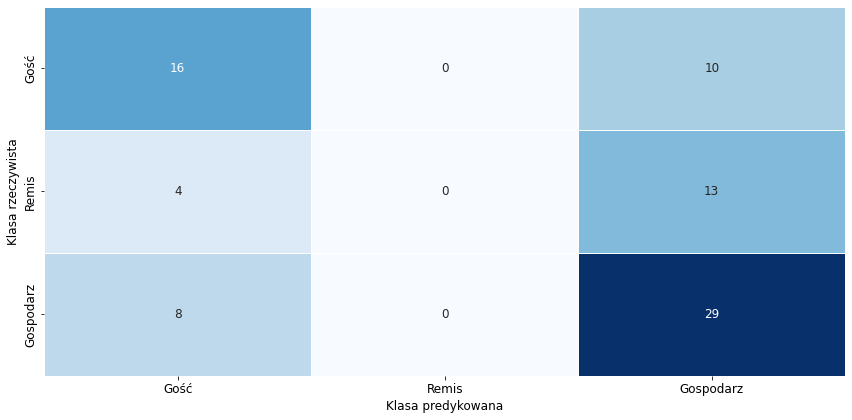

Accuracy score: 56.25%
Precision score: 44.36%
Recall score: 56.25%
---------------------------------


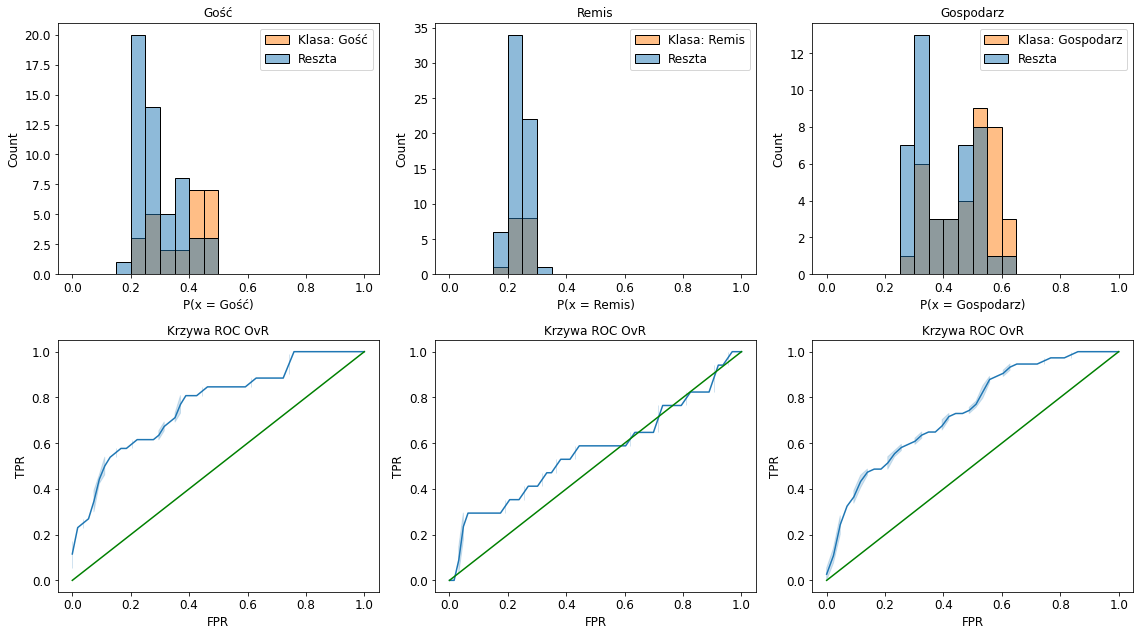

0 ROC AUC OvR: 0.7699
1 ROC AUC OvR: 0.5668
2 ROC AUC OvR: 0.7366
average ROC AUC OvR: 0.6911
---------------------------------


In [6]:
grid=joblib.load('grid_XGBoost_20kolejek.pkl')

classifier_plots(grid)

In [8]:
grid.best_score_

0.5833333333333333

In [43]:
functions.grid_to_predictions(grid,'XGBoost_20kolejek',y_test_adh,X_test)

# Random Search

In [44]:
parameters={
    'classifier__learning_rate' : [0.01,0.05,0.1,0.25],
    'classifier__n_estimators':list(range(100,1000,200)),
    'classifier__max_depth':list(range(2,10,2)),
    'classifier__min_child_weight':list(range(0,6,2)),
    'classifier__gamma':[i/10.0 for i in range(0,5)],
    'classifier__subsample':[i/10.0 for i in range(6,10)],
    'classifier__colsample_bytree':[i/10.0 for i in range(6,10)],
    'classifier__objective': ['multi:softmax'],
    'classifier__nthread':[4],
    'classifier__seed':[1], 
    'classifier__num_class':[3],
    'classifier__reg_alpha':[0,1e-5, 1e-2, 0.1, 1, 100],
    'classifier__reg_lambda':[10,1e-5, 1e-2, 0.1, 1, 100]}

In [45]:
def run_classifier_rs(clf, param_grid, title,X_train,y_train):
    # -----------------------------------------------------
    
    pipe = Pipeline([
    ('classifier', clf)
    ])

    # -----------------------------------------------
    
    scoring = {"Accuracy": 'accuracy',"Log_loss":'neg_log_loss',"Precision":make_scorer(precision_score, average = 'macro'),'Recall': make_scorer(recall_score, average = 'macro'),
               'Matthews_corrcoef': make_scorer(matthews_corrcoef),'F1_score':'f1_macro',"AUC":roc_auc_ovr_scorer, 'RPS': rps_scorer}
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
    grid = RandomizedSearchCV(pipe, param_grid, n_iter=50,cv=cv,scoring=scoring,refit='Accuracy',n_jobs=-1,verbose=1).fit(X_train, y_train)

    # -----------------------------------------------------
    print("The best parameters are %s" % (grid.best_params_)) 

    #y_pred = grid.best_estimator_.predict(X_test)
    #y_proba = grid.best_estimator_.predict_proba(X_test)

    # -----------------------------------------------------

    joblib.dump(grid, 'grid_'+title+'.pkl')

    #------------------------------------------------

In [46]:
clf=xgb.XGBClassifier()

run_classifier_rs(clf, param_grid=parameters, title='XGBoost_RS_20kolejek',X_train=X_train,y_train=y_train)

Fitting 15 folds for each of 50 candidates, totalling 750 fits
The best parameters are {'classifier__subsample': 0.8, 'classifier__seed': 1, 'classifier__reg_lambda': 100, 'classifier__reg_alpha': 1, 'classifier__objective': 'multi:softmax', 'classifier__num_class': 3, 'classifier__nthread': 4, 'classifier__n_estimators': 300, 'classifier__min_child_weight': 2, 'classifier__max_depth': 4, 'classifier__learning_rate': 0.01, 'classifier__gamma': 0.2, 'classifier__colsample_bytree': 0.8}


In [50]:
grid=joblib.load('grid_XGBoost_RS_20kolejek.pkl')
print(grid.best_score_)
print(grid.score(X_test,y_test))
#classifier_plots(grid)

0.59
0.55


# Gridsearch

In [51]:
parameters={
    'classifier__learning_rate' : [0.01,0.1],
    'classifier__n_estimators':[10,100,500],
    'classifier__max_depth':[2,5,10],
    'classifier__min_child_weight':[0,3,6],
    'classifier__gamma':[i/10.0 for i in range(0,4,4)],
    'classifier__subsample':[i/10.0 for i in range(6,10,4)],
    'classifier__colsample_bytree':[i/10.0 for i in range(6,10,4)],
    'classifier__objective': ['multi:softmax'],
    'classifier__nthread':[4],
    'classifier__seed':[1], 
    'classifier__num_class':[3],
    'classifier__reg_alpha':[0, 0.1, 1, 100],
    'classifier__reg_lambda':[0, 0.1, 1, 100]}

In [52]:
clf=xgb.XGBClassifier()

run_classifier(clf, param_grid=parameters, title='XGBoost_GS_20kolejek',X_train=X_train,y_train=y_train)

Fitting 15 folds for each of 864 candidates, totalling 12960 fits
The best parameters are {'classifier__colsample_bytree': 0.6, 'classifier__gamma': 0.0, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 2, 'classifier__min_child_weight': 0, 'classifier__n_estimators': 100, 'classifier__nthread': 4, 'classifier__num_class': 3, 'classifier__objective': 'multi:softmax', 'classifier__reg_alpha': 1, 'classifier__reg_lambda': 100, 'classifier__seed': 1, 'classifier__subsample': 0.6}


In [53]:
grid=joblib.load('grid_XGBoost_GS_20kolejek.pkl')
print(grid.best_score_)
print(grid.score(X_test,y_test))
#classifier_plots(grid)

0.5916666666666667
0.5625
